# Validation of HyFS fluxes

In [90]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import pandas as pd
import numpy as np
import glob
import metview as mv
import xarray as xr
execfile("utils.py")
%matplotlib inline

In [34]:
#model data directory
dir="/home/lauracma/Documents/ecmwf_proj/data/model_fluxes/analysis_data/raw_data/hyfs_rd/2020/"
files=np.sort(glob.glob(dir+"/*"))

#obs data
dir_obs="/home/lauracma/Documents/ecmwf_proj/data/ISMN_data/in_situ_data/pre_processed_data/ICOS_FLUXNET/2020/"

#meta data ICOS stations 2020
meta=np.loadtxt("/home/lauracma/Documents/ecmwf_proj/data/ISMN_data/in_situ_data/pre_processed_data/station_info/ICOS_FLUXNET/station_coords_2020",
                str, comments="%", skiprows=1)
meta

array([['BE-Bra', '51.30761', '4.51984', '16', 'Cfb', '3'],
       ['BE-Vie', '50.304962', '5.998099', '490', 'Cfb', '18'],
       ['DE-Tha', '50.96256', '13.56515', '380', 'Cfb', '3'],
       ['DK-Sor', '55.48587', '11.644645', '40', 'Cfb', '5'],
       ['FI-Hyy', '61.84741', '24.29477', '181', 'Dfc', '3'],
       ['CH-Dav', '46.81533', '9.85591', '1689', 'Dfc', '3'],
       ['RU-Fyo', '56.461528', '32.922083', '274', 'Dfc', '3'],
       ['IT-Ren', '46.58686', '11.43369', '1735', 'Dfc', '3'],
       ['DE-Hai', '51.079407', '10.452089', '438', 'Dfb', '6'],
       ['IL-Yat', '31.345045', '35.051989', '657', 'Dfb', '6'],
       ['DE-Geb', '51.09973', '10.91463', '161', 'Cfb', '1'],
       ['SE-Deg', '64.18203', '19.55654', '270', 'Dfc', '13'],
       ['IT-Lav', '45.9562', '11.28132', '1355', 'Dfc', '3'],
       ['BE-Lon', '50.55162', '4.746234', '170', 'Cfb', '1'],
       ['CH-Lae', '47.47808', '8.365', '689', 'Dfc', '3'],
       ['CH-Oe2', '47.28631', '7.73433', '452', 'Dfb', '1'],
    

## Validation at one station

In [35]:
#select station from above's meta data file
idx=50
meta_station=meta[idx,]
meta_station

array(['FR-Hes', '48.6741', '7.06465', '310', 'Cfb', '5'], dtype='<U9')

In [73]:
#observational data at selected station
lat=float(meta_station[1])
lon=float(meta_station[2])
f=glob.glob(dir_obs+"/ICOS_FLUXNET_"+str(round(lat,4))+"*"+str(round(lon,4))+"*")
dat=pd.read_pickle(f[0])
sh_obs_orig=dat["H_CORR"]
lh_obs_orig=dat["LE_CORR"]
sh_obs=acc_deacc_6h(sh_obs_orig[::2])
lh_obs=acc_deacc_6h(lh_obs_orig[::2])

In [37]:
#prepare model data
dat=mv.Fieldset()
sh=mv.Fieldset()
lh=mv.Fieldset()
for i in range(12):
    tmp=mv.read(files[i])
    dat.append(tmp)
    sh_tmp=tmp["sshf"]
    sh.append(sh_tmp)
    lh_tmp=tmp["slhf"]
    lh.append(lh_tmp)

In [39]:
dat.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
slhf,surface,0,"20200101,20200201,...",0,"6,12,...",147,rd,oper,fc,hyfs
sshf,surface,0,"20200101,20200201,...",0,"6,12,...",146,rd,oper,fc,hyfs


In [41]:
coords=[lat,lon]
sh_mod=np.array(sh.nearest_gridpoint(coords))/(3600*6*-1)
lh_mod=np.array(lh.nearest_gridpoint(coords))/(3600*6*-1)

#deaccumulation
sh_mod=deacc_hyfs(sh_mod)
lh_mod=deacc_hyfs(lh_mod)

In [62]:
#check dimensions
print("dimension model: ", str(np.shape(sh_mod)))
print("dimension model (theoretically): ", str(4*366))
print("dimension obs: ", str(np.shape(sh_obs_orig)))
print("dimension obs (theoretically): ", str(48*366))
print("dimension obs reshaped: ", str(np.shape(sh_obs)))
print("dimension obs reshaped (theoretically): ", str(4*366))

dimension model:  (1464,)
dimension model (theoretically):  1464
dimension obs:  (17568,)
dimension obs (theoretically):  17568
dimension obs reshaped:  (1464,)
dimension obs reshaped (theoretically):  1464


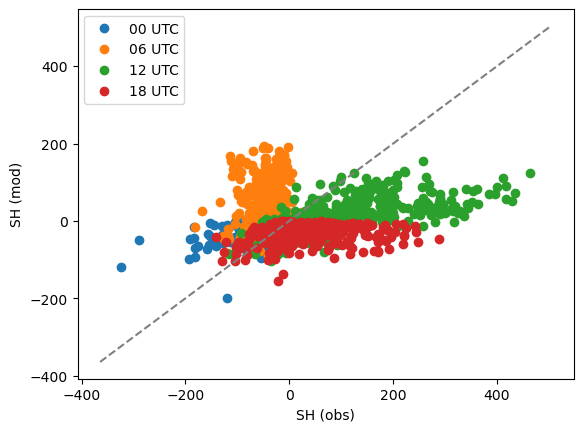

In [74]:
plt.plot(sh_obs[0::4],sh_mod[0::4],"o",label="00 UTC")
plt.plot(sh_obs[1::4],sh_mod[1::4],"o",label="06 UTC")
plt.plot(sh_obs[2::4],sh_mod[2::4],"o",label="12 UTC")
plt.plot(sh_obs[3::4],sh_mod[3::4],"o",label="18 UTC")
plt.xlabel("SH (obs)")
plt.ylabel("SH (mod)")
plt.legend()
abline(1,0)

In [75]:
sh_obs_seasonal_cycle=mean_seasonal_cycle(sh_obs)
lh_obs_seasonal_cycle=mean_seasonal_cycle(lh_obs)
sh_mod_seasonal_cycle=mean_seasonal_cycle(sh_mod)
lh_mod_seasonal_cycle=mean_seasonal_cycle(lh_mod)

Text(0, 0.5, 'flux [W/m$^2$]')

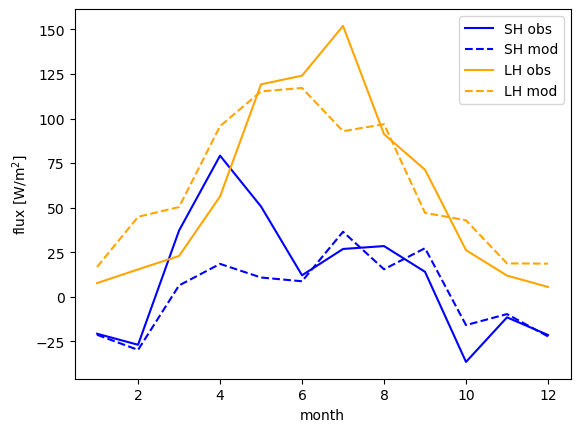

In [80]:
maxis=np.linspace(1,12,12)
plt.plot(maxis,sh_obs_seasonal_cycle,color="blue",label="SH obs")
plt.plot(maxis,sh_mod_seasonal_cycle,"--",color="blue",label="SH mod")
plt.plot(maxis,lh_obs_seasonal_cycle,color="orange",label="LH obs")
plt.plot(maxis,lh_mod_seasonal_cycle,"--",color="orange",label="LH mod")
plt.legend()
plt.xlabel("month")
plt.ylabel(r"flux [W/m$^2$]")

## Validate all stations

In [81]:
nstations=np.shape(meta)[0]
#sh
sh_cors00=np.zeros(nstations)
sh_cors06=np.zeros(nstations)
sh_cors12=np.zeros(nstations)
sh_cors18=np.zeros(nstations)
sh_day_av=np.zeros(nstations)
sh_day_av_md=np.zeros(nstations)
sh_md12=np.zeros(nstations)
sh_md00=np.zeros(nstations)
#lh
lh_cors00=np.zeros(nstations)
lh_cors06=np.zeros(nstations)
lh_cors12=np.zeros(nstations)
lh_cors18=np.zeros(nstations)
lh_day_av=np.zeros(nstations)
lh_day_av_md=np.zeros(nstations)
lh_md12=np.zeros(nstations)
lh_md00=np.zeros(nstations)

In [104]:
#2: go through icos stations
for i in range(np.shape(meta)[0]):
    print(i)
    meta_station=meta[i,]
    lat=float(meta_station[1])
    lon=float(meta_station[2])
    try:
        f=glob.glob(dir_obs+"/ICOS_FLUXNET_"+str(round(lat,4))+"*"+str(round(lon,4))+"*")
        dat=pd.read_pickle(f[0])
        sh_obs=dat["H_CORR"]
        lh_obs=dat["LE_CORR"]
        #nearest neighbor
        coords=[lat,lon]
        sh_mod=np.array(sh.nearest_gridpoint(coords))/(3600*6*-1)
        lh_mod=np.array(lh.nearest_gridpoint(coords))/(3600*6*-1)
        #deacc model data
        sh_mod=deacc_hyfs(sh_mod)
        lh_mod=deacc_hyfs(lh_mod)
        #acc obs data
        sh_obs=acc_deacc_6h(sh_obs[::2])
        lh_obs=acc_deacc_6h(lh_obs[::2])
        #calc correlation
        sh_cors00[i]=np.corrcoef(sh_mod[0::4],sh_obs[0::4])[0,1]
        sh_cors06[i]=np.corrcoef(sh_mod[1::4],sh_obs[1::4])[0,1]
        sh_cors12[i]=np.corrcoef(sh_mod[2::4],sh_obs[2::4])[0,1]
        sh_cors18[i]=np.corrcoef(sh_mod[3::4],sh_obs[3::4])[0,1]
        lh_cors00[i]=np.corrcoef(lh_mod[0::4],lh_obs[0::4])[0,1]
        lh_cors06[i]=np.corrcoef(lh_mod[1::4],lh_obs[1::4])[0,1]
        lh_cors12[i]=np.corrcoef(lh_mod[2::4],lh_obs[2::4])[0,1]
        lh_cors18[i]=np.corrcoef(lh_mod[3::4],lh_obs[3::4])[0,1]
        #mean deviation per hours
        sh_md12[i]=np.nanmean(sh_mod[2::4]-sh_obs[2::4])
        sh_md00[i]=np.nanmean(sh_mod[0::4]-sh_obs[0::4])
        lh_md12[i]=np.nanmean(lh_mod[2::4]-lh_obs[2::4])
        lh_md00[i]=np.nanmean(lh_mod[0::4]-lh_obs[0::4])
        #daily average
        sh_mod_av_st=daily_av(sh_mod)
        lh_mod_av_st=daily_av(lh_mod)
        sh_obs_av_st=daily_av(sh_obs)
        lh_obs_av_st=daily_av(lh_obs)
        sh_day_av[i]=np.corrcoef(sh_mod_av_st,sh_obs_av_st)[0,1]
        lh_day_av[i]=np.corrcoef(lh_mod_av_st,lh_obs_av_st)[0,1]
        sh_day_av_md[i]=np.nanmean(sh_mod_av_st-sh_obs_av_st)
        lh_day_av_md[i]=np.nanmean(lh_mod_av_st-lh_obs_av_st)
        #partitioning of daily average
        #b_obs[i]=np.nanmean(sh_obs_av_st/lh_obs_av_st)
        #b_mod[i]=np.nanmean(sh_mod_av_st/lh_mod_av_st)
        #b_cor[i]=np.corrcoef(sh_mod_av_st/lh_mod_av_st,sh_obs_av_st/lh_obs_av_st)
    except:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


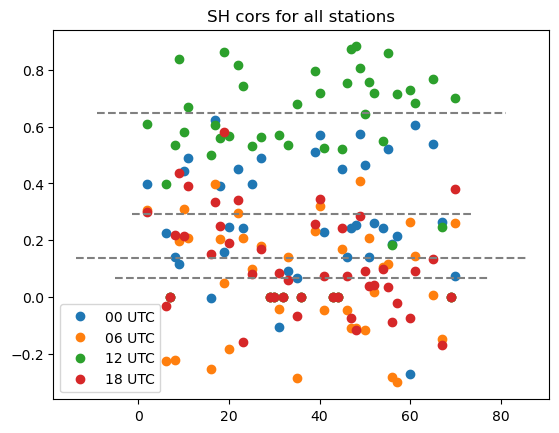

In [83]:
x=np.sort(meta[:,1])
plt.plot(sh_cors00,"o",label="00 UTC")
plt.plot(sh_cors06,"o",label="06 UTC")
plt.plot(sh_cors12,"o",label="12 UTC")
plt.plot(sh_cors18,"o",label="18 UTC")
plt.title("SH cors for all stations")
abline(0,np.nanmean(sh_cors00[sh_cors00!=0]))
abline(0,np.nanmean(sh_cors06[sh_cors06!=0]))
abline(0,np.nanmean(sh_cors12[sh_cors12!=0]))
abline(0,np.nanmean(sh_cors18[sh_cors18!=0]))
plt.legend()

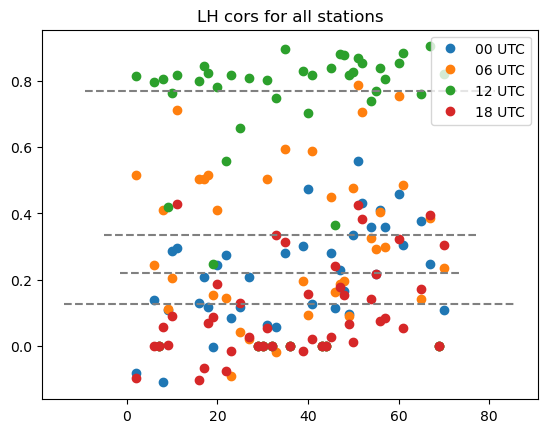

In [84]:
plt.plot(lh_cors00,"o",label="00 UTC")
plt.plot(lh_cors06,"o",label="06 UTC")
plt.plot(lh_cors12,"o",label="12 UTC")
plt.plot(lh_cors18,"o",label="18 UTC")
plt.title("LH cors for all stations")
abline(0,np.nanmean(lh_cors00[lh_cors00!=0]))
abline(0,np.nanmean(lh_cors06[lh_cors06!=0]))
abline(0,np.nanmean(lh_cors12[lh_cors12!=0]))
abline(0,np.nanmean(lh_cors18[lh_cors18!=0]))
plt.legend()

(0.37, 1.0)

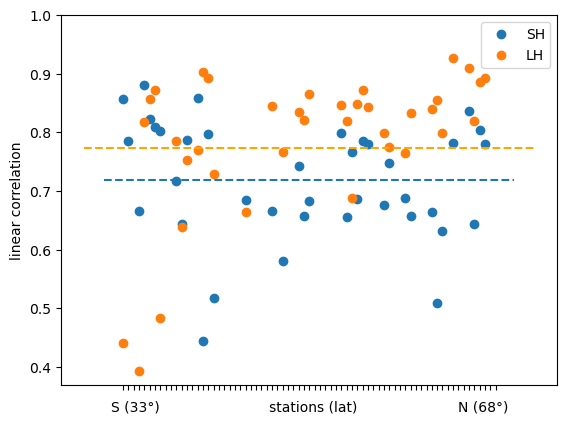

In [105]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
ax.plot(x,sh_day_av[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_day_av[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel("linear correlation")
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_day_av[sh_day_av!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_day_av[lh_day_av!=0]),col="orange")
ax.set_ylim((0.37,1))

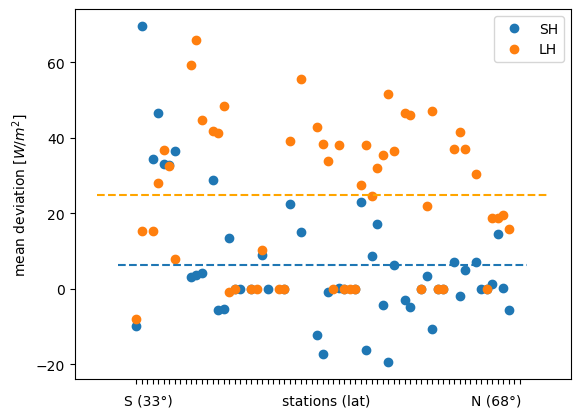

In [107]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_day_av_md[sh_day_av_md==0.0]='nan'
lh_day_av_md[lh_day_av_md==0.0]='nan'
ax.plot(x,sh_day_av_md[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_day_av_md[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel(r'mean deviation [$W/m^2$]')
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_day_av_md[sh_day_av!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_day_av_md[lh_day_av!=0]),col="orange")
#ax.set_ylim((0.37,1))

(0.0, 1.0)

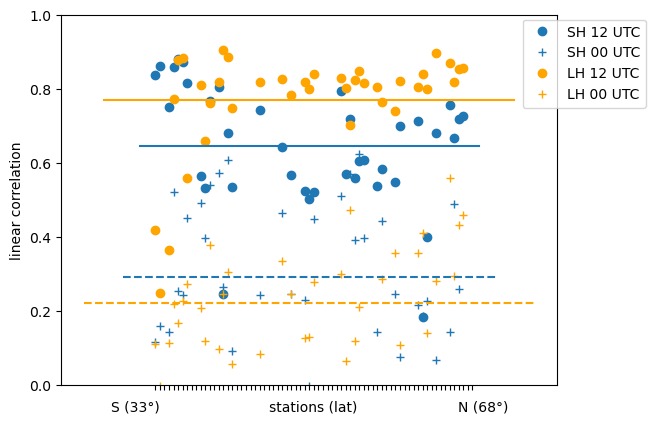

In [87]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_cors12[sh_cors12==0]='nan'
sh_cors00[sh_cors00==0]='nan'
lh_cors12[lh_cors12==0]='nan'
lh_cors00[lh_cors00==0]='nan'
ax.plot(x,sh_cors12[np.argsort(meta[:,1])],"o",label="SH 12 UTC",color='#1f77b4')
ax.plot(x,sh_cors00[np.argsort(meta[:,1])],"+",label="SH 00 UTC",color='#1f77b4')
ax.plot(x,lh_cors12[np.argsort(meta[:,1])],"o",label="LH 12 UTC",color='orange')
ax.plot(x,lh_cors00[np.argsort(meta[:,1])],"+",label="LH 00 UTC",color='orange')
ax.axes.set_ylabel("linear correlation")
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend(loc=(0.93,0.75))
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_cors12),lty="-",col='#1f77b4')
abline(0,np.nanmean(sh_cors00),col='#1f77b4')
abline(0,np.nanmean(lh_cors12),lty="-",col='orange')
abline(0,np.nanmean(lh_cors00),col='orange')
ax.set_ylim((0,1))

(-230.0, 50.0)

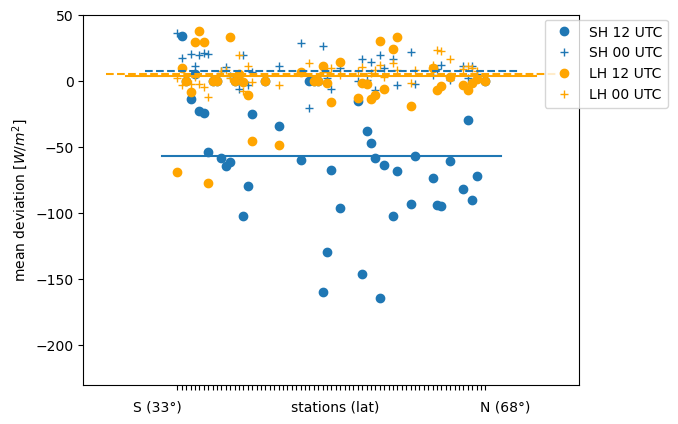

In [88]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_md12[sh_cors12==0]='nan'
sh_md00[sh_cors00==0]='nan'
lh_md12[lh_cors12==0]='nan'
lh_md00[lh_cors00==0]='nan'
ax.plot(x,sh_md12[np.argsort(meta[:,1])],"o",label="SH 12 UTC",color='#1f77b4')
ax.plot(x,sh_md00[np.argsort(meta[:,1])],"+",label="SH 00 UTC",color='#1f77b4')
ax.plot(x,lh_md12[np.argsort(meta[:,1])],"o",label="LH 12 UTC",color='orange')
ax.plot(x,lh_md00[np.argsort(meta[:,1])],"+",label="LH 00 UTC",color='orange')
ax.axes.set_ylabel(r"mean deviation [$W/m^2$]")
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend(loc=(0.93,0.75))
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_md12),lty="-",col='#1f77b4')
abline(0,np.nanmean(sh_md00),col='#1f77b4')
abline(0,np.nanmean(lh_md12),lty="-",col='orange')
abline(0,np.nanmean(lh_md00),col='orange')
ax.set_ylim((-230,50))